## Our Implementation

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.cluster import KMeans

from scipy.stats import anderson
from sklearn.datasets.samples_generator import make_blobs
from sklearn import cluster, datasets, mixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale, StandardScaler


In [42]:
# simple helper class contains useful method to draw shape
class Tools:
    @staticmethod
    def drawCentroids(centroids='ro'):
        plt.plot(centroids[:, 0], centroids[:, 1], 'ro')

    @staticmethod
    def drawDataSet(X, symbol):
        plt.plot(X[:, 0], X[:, 1], symbol)

    @staticmethod
    def distBetween(a, b):
        return np.sqrt(np.power(a[0]-b[0], 2) + np.power(a[1] - b[1], 2))

    @staticmethod
    def generateSomeData(start, end, numbers):
        pass

    @staticmethod
    def exchange_binary_image_white_black(img):
        # img is an binary img
        img = img.convert('L')
        pixels = np.array(img)
        threshold = 100

        rows = len(pixels)
        cols = len(pixels[0])

        for i in range(rows):
            for j in range(cols):
                if pixels[i][j] > threshold:
                    pixels[i][j] = 0
                else:
                    pixels[i][j] = 255

        return pixels


    @staticmethod
    def drawClusters(clusters):
        Ys = np.array([[4, 8, 12, 16],
                       [1, 4, 9, 16],
                       [17, 10, 13, 18],
                       [9, 10, 18, 11],
                       [4, 15, 17, 6],
                       [7, 10, 8, 7],
                       [9, 0, 10, 11],
                       [14, 1, 15, 5],
                       [8, 15, 9, 14],
                       [20, 7, 1, 5]])

        colors = cm.rainbow(np.linspace(0, 1, len(Ys)))

        for label in range(len(clusters)):
            for each in clusters[label]:
                plt.scatter(each[0], each[1], s=1, c=colors[label % len(colors)])

    @staticmethod
    def draw(X, lables, centroids=[], title=None, interim_centers=None):
        Ys = np.array([[4, 8, 12, 16],
                       [1, 4, 9, 16],
                       [17, 10, 13, 18],
                       [9, 10, 18, 11],
                       [4, 15, 17, 6],
                       [7, 10, 8, 7],
                       [9, 0, 10, 11],
                       [14, 1, 15, 5],
                       [8, 15, 9, 14],
                       [20, 7, 1, 5]])

        colors = cm.rainbow(np.linspace(0, 1, len(Ys)))
        fig = plt.gcf()
        if title != None:
            fig.canvas.set_window_title(title)

        # draw centroid
        if len(centroids) > 0:
            for c in centroids:
                plt.plot(c[0], c[1], 'ro')
                
#         # if want to show all the centroids generated during spliting
#         if interim_centers != None:
#             if len(interim_centers) > 0:
#                 for c in interim_centers:
#                     plt.plot(c[0], c[1], 'g*')


        # draw each point
        for i in range(len(lables)):
            p = X[i]
            label = lables[i]
            plt.scatter(p[0], p[1], s=1, c=colors[label % len(colors)])

        if title != None:
            print "use {}, k = {}".format(title, len(centroids))

In [3]:
# This Xmeans implementation is copied from other people's work from GitHub
class XMeans(KMeans):
    def __init__(self, k_init = 2, **k_means_args):
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        km = KMeans(self.k_init, **self.k_means_args).fit(X)
        self.cluster_centers_ = list(km.cluster_centers_)
        self.labels_, _ = self.__recrucive_clustering(X, km.labels_, np.unique(km.labels_), np.max(km.labels_))
        self.cluster_centers_ = np.array(self.cluster_centers_)
        return self

    def __recrucive_clustering(self, X, labels, labelset, splits):
        for label in labelset:
            cluster = X[labels == label]
            if len(cluster) <= 3: continue
            km = KMeans(2, **self.k_means_args).fit(cluster)
            if self.__recrucive_decision(cluster, km.labels_, km.cluster_centers_):
                self.cluster_centers_[label] = km.cluster_centers_[0]
                self.cluster_centers_.append(km.cluster_centers_[1])
                km.labels_[km.labels_ == 1] += splits
                km.labels_[km.labels_ == 0] += label
                labels[labels == label], splits = self.__recrucive_clustering(cluster, km.labels_, [label, splits+1], splits+1)
        return labels, splits

    def __recrucive_decision(self, cluster, labels, centers):
        samples = cluster.shape[0]
        parameters = cluster.shape[1] * (cluster.shape[1] + 3) / 2
        bic = self.__bic(cluster, None, samples, parameters)
        new_bic = self.__bic(cluster[labels == 0], cluster[labels == 1], samples, parameters*2)
        return bic > new_bic

    def __bic(self, cluster_0, cluster_1, samples, parameters):
        if cluster_1 is not None:
            alpha = self.__model_likelihood(cluster_0, cluster_1)
            return -2.0 * (samples * np.log(alpha) + self.__log_likelihood(cluster_0) + self.__log_likelihood(cluster_1)) + parameters * np.log(samples)
        else:
            return -2.0 * self.__log_likelihood(cluster_0) + parameters * np.log(samples)

    def __model_likelihood(self, cluster_0, cluster_1):
        mu_0, mu_1 = np.mean(cluster_0, axis=0), np.mean(cluster_1, axis=0)
        sigma_0, sigma_1 = np.cov(cluster_0.T) , np.cov(cluster_1.T)
        det_0 = np.linalg.det(sigma_0) if len(cluster_0) > 1 else 0.0
        det_1 = np.linalg.det(sigma_1) if len(cluster_1) > 1 else 0.0
        beta = np.linalg.norm(mu_0 - mu_1) / np.sqrt(det_0 + det_1)
        return 0.5 / stats.norm.cdf(beta)

    def __log_likelihood(self, cluster):
        if len(cluster) == 1: return np.log(1.0)
        mu = np.mean(cluster, axis=0)
        sigma = np.cov(cluster.T)
        try:
            log_likehood = np.sum(stats.multivariate_normal.logpdf(x, mu, sigma) for x in cluster)
        except np.linalg.LinAlgError as err:
            sigma = sigma * np.identity(sigma.shape[0])
            log_likehood = np.sum(stats.multivariate_normal.logpdf(x, mu, sigma) for x in cluster)
        return log_likehood

    def predict(self):
        return self.labels_

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [4]:
# This is our first version of G-means, which during the split part, init='k-means++'
class GMeans_01:
    def __init__(self, strictlevel=4):
        self.stricklevel = strictlevel
        self.centroids = []
        self.clusters = []
        self.index_records = []
        self.X = None
        self.labels = []
        self.index_result = []
        self.interim_centroids = []

    def __recursive_cluster_index(self, indexes):
        if len(indexes) < 2:
            return
        original_indexes = []
        for index in indexes:
            original_indexes.append(index)

        centroid = np.mean(self.X[indexes], axis=0)
        # no intialize centroid, just use k++
        km = self.KMeans().split(dataSet=self.X, index_records=indexes)
        self.interim_centroids.append(km.c_0.copy())
        self.interim_centroids.append(km.c_1.copy())
        v = km.c_0 - km.c_1

        X_prime = self.get_X_prime(self.X[indexes], v)
        accept_split = self.checkAnderson(X_prime)

        if accept_split:
            # km.cluster_0 should be the index_records
            self.__recursive_cluster_index(km.index_records_0)
            self.__recursive_cluster_index(km.index_records_1)
        else:
            self.centroids.append(centroid)
            self.index_result.append(original_indexes)

    def fit(self, X):
        self.X = X.copy()
        for i in range(len(X)):
            self.index_records.append(i)
        # self.index_records = np.asarray(self.index_records)

        self.__recursive_cluster_index(self.index_records)
        self.centroids = np.array(self.centroids)

        # print len(self.centroids), type(self.centroids)
        # print len(self.index_result), type(self.index_result)
        # generate lables
        self.labels = np.zeros(len(self.index_records))
        for label in range(len(self.index_result)):
            for each in self.index_result[label]:
                self.labels[each] = label

        self.labels = np.asarray(self.labels).astype(int)
        return self

    def get_X_prime(self, X, v):
        X_copy = X.copy()
        # normalize v, need?
        v = v / np.sqrt(v.T * v)
        X_prime = scale(X_copy.dot(v) / (v.dot(v)))

        return X_prime

    def checkAnderson(self, X):
        X = X - np.mean(X)
        output = anderson(X)
        statistic = output[0]
        critical_value = output[1][self.stricklevel]
        if np.isnan(statistic):
            return False

        # print statistic, critical_value
        if statistic > critical_value:
            return True
        else:
            return False

    # inner class for doing the K-Means clustering
    class KMeans:
        def __init__(self):
            self.centroids = np.array([])
            self.index_records_0 = []
            self.index_records_1 = []
            self.c_0 = None
            self.c_1 = None

        def split(self, dataSet, index_records):
            # print "\nindex_records length = {}".format(len(index_records))
            # print "index_records = {}".format(index_records)
            # print "in gm_01, we use k-mean++ to initialize"
            kM = KMeans(n_clusters=2, init='k-means++').fit(dataSet[index_records])

            self.c_0 = kM.cluster_centers_[0]
            self.c_1 = kM.cluster_centers_[1]

            for index in range(len(index_records)):
                if kM.labels_[index] == 0:
                    self.index_records_0.append(index_records[index])
                else:
                    self.index_records_1.append(index_records[index])

            return self

In [5]:
# This is our second version of G-means, which follows the same procedures the paper used.
# Which during the split part, the K-means algorith use two specified centroids for initialization
class GMeans_02:
    def __init__(self, strictlevel=4):
        self.stricklevel = strictlevel
        self.centroids = []
        self.clusters = []
        self.index_records = []
        self.X = None
        self.labels = []
        self.index_result = []

    def __recursive_cluster_index(self, indexes):
        if len(indexes) < 2:
            return
        original_indexes = []
        for index in indexes:
            original_indexes.append(index)

        centroid = np.mean(self.X[indexes], axis=0)
        # compute eigen vector and eigen values
        W0, ev0 = self.powerPCA(data=self.X[indexes], n_pcs=1)
        m = W0 * np.sqrt(2 * ev0 / 3.1415926)
        # c_0, c_1: 2 by 1 matrix
        c_0 = np.matrix(centroid).getT() + m
        c_1 = np.matrix(centroid).getT() - m
        km = self.KMeans(c_0, c_1).split(dataSet=self.X, index_records=indexes)
        v = km.c_0 - km.c_1

        X_prime = self.get_X_prime(self.X[indexes], v)

        accept_split = self.checkAnderson(X_prime)

        if accept_split:
            # km.cluster_0 should be the index_records
            self.__recursive_cluster_index(km.index_records_0)
            self.__recursive_cluster_index(km.index_records_1)
        else:
            self.centroids.append(centroid)
            self.index_result.append(original_indexes)

    def fit(self, X):
        self.X = X.copy()
        for i in range(len(X)):
            self.index_records.append(i)
        # self.index_records = np.asarray(self.index_records)

        self.__recursive_cluster_index(self.index_records)
        self.centroids = np.array(self.centroids)

        # print len(self.centroids), type(self.centroids)
        # print len(self.index_result), type(self.index_result)
        # generate lables
        self.labels = np.zeros(len(self.index_records))
        for label in range(len(self.index_result)):
            for each in self.index_result[label]:
                self.labels[each] = label

        self.labels = np.asarray(self.labels).astype(int)
        return self

    def get_X_prime(self, X, v):
        X_copy = X.copy()
        # normalize v, need?
        v = v / np.sqrt(v.T * v)
        X_prime = scale(X_copy.dot(v) / (v.dot(v)))

        return X_prime

        # X_prime = (X * v).tolist()
        # tmp = []
        # for each in X_prime:
        #     tmp.append(each[0])
        #
        # return tmp

    def checkAnderson(self, X):
        X = X - np.mean(X)
        output = anderson(X)
        statistic = output[0]
        critical_value = output[1][self.stricklevel]
        if np.isnan(statistic):
            return False

        # print statistic, critical_value
        if statistic > critical_value:
            return True
        else:
            return False

    # Power method
    def power_iterations(self, R, w):
        while 1:
            w1 = w.copy()
            w = R * w
            w /= LA.norm(w)
            if self.converged(w, w1):
                break
        return w

        # test whether two normalized vectors are the same (or deviation within a threshold)

    def converged(self, w, w1, thres=1e-10):
        converged = False
        corr = w.T * w1
        # print corr
        if abs(corr) > 1 - thres:
            converged = True
        return converged

    def powerPCA(self, data, n_pcs):
        nr, dim = data.shape
        X = np.matrix(data)
        m = np.mean(data, axis=0)
        R = (X - m).T * (X - m) / (nr - 1.0)
        R0 = R.copy()

        # initialize
        w = np.matrix(np.random.rand(dim)).T
        w /= LA.norm(w)
        # iterate for 1st eigenvector
        w = self.power_iterations(R, w)
        # first eigenvector as first column of W
        W = w
        # iterate for other eigenvectors
        for i in range(1, n_pcs):
            # deflate R
            R -= w * w.T * R
            # initialize and Power iter
            w = np.matrix(np.random.rand(dim)).T
            w /= LA.norm(w)
            w = self.power_iterations(R, w)
            # attach the new eigenvector to W as a new column
            W = np.c_[W, w]

        # get eigenvalues and save them in the ev array
        y = R0 * W
        ev = LA.norm(y, axis=0) / LA.norm(W, axis=0)
        return W, ev

    # inner class for doing the K-Means clustering
    class KMeans:
        def __init__(self, c_0, c_1):
            self.centroids = np.array([])
            self.index_records_0 = []
            self.index_records_1 = []
            self.c_0 = c_0
            self.c_1 = c_1

        def split(self, dataSet, index_records):
            # print "\nindex_records length = {}".format(len(index_records))
            # print "index_records = {}".format(index_records)
            c0 = np.squeeze(np.asarray(self.c_0))
            c1 = np.squeeze(np.asarray(self.c_1))
            initial_centroids = np.stack((c0, c1))
            # print "in gm_02, we use initial_centroids to initialize"
            kM = KMeans(n_clusters=2, init=initial_centroids).fit(dataSet[index_records])

            self.c_0 = kM.cluster_centers_[0]
            self.c_1 = kM.cluster_centers_[1]

            for index in range(len(index_records)):
                if kM.labels_[index] == 0:
                    self.index_records_0.append(index_records[index])
                else:
                    self.index_records_1.append(index_records[index])

            return self

In [26]:
# contains some helper methods to do the experiments
def demo1():
    X, y = make_blobs(n_samples=200, centers=5, n_features=2, random_state=100)
    X = StandardScaler().fit_transform(X)
    gm = GMeans_01().fit(X)
    print "found {} centroids".format(len(gm.centroids))
    Tools.draw(X=X, lables=gm.labels, centroids=gm.centroids)

def demo3():
    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=1000, centers=7, n_features=2, random_state=random_state)
    X = StandardScaler().fit_transform(X)

    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)

    gm = GMeans_02().fit(X_aniso)

    print "found {} clusters".format(len(gm.clusters))
    print "found {} centroids".format(len(gm.centroids))
    Tools.drawCentroids(gm.centroids)
    Tools.drawClusters(gm.clusters)


def demo_XMean():
    random_state = 170
    X, y = datasets.make_blobs(n_samples=1000, centers=7, n_features=2, random_state=random_state)
    X = StandardScaler().fit_transform(X)
    xm = XMeans()
    xm = xm.fit(X)

    Tools.draw(X=X, lables=xm.labels_, centroids=xm.cluster_centers_, interim_centers=None)


def summary(n_samples, min_n_clusters, max_n_clusters, n_features, random_state=0, n_loops=10):
    gm_01_scores = []
    gm_02_scores = []
    xm_scores = []

    for n_cluster in np.linspace(min_n_clusters, max_n_clusters, max_n_clusters - min_n_clusters + 1):
        total_gm_01_score = 0
        total_gm_02_score = 0
        total_xm_score = 0

        for i in range(n_loops):
            n_cluster = n_cluster.astype(int)
            X, y = datasets.make_blobs(n_samples=n_samples, n_features=n_features, centers=n_cluster,
                                       random_state=random_state)
            X = StandardScaler().fit_transform(X)

            X_1 = X.copy()
            X_2 = X.copy()
            X_3 = X.copy()

            gm_01 = GMeans_01().fit(X_1)
            gm_02 = GMeans_02().fit(X_2)
            xm = XMeans().fit(X_3)

            gm_01_score = silhouette_score(X_1, gm_01.labels, metric='euclidean')
            gm_02_score = silhouette_score(X_2, gm_02.labels, metric='euclidean')
            xm_score = silhouette_score(X_3, xm.labels_, metric='euclidean')

            # print "xm = {}".format(xm_score)

            total_gm_01_score += gm_01_score
            total_gm_02_score += gm_02_score
            total_xm_score += xm_score

        total_gm_01_score = total_gm_01_score / (n_loops * 1.0)
        total_gm_02_score = total_gm_02_score / (n_loops * 1.0)
        total_xm_score = total_xm_score / (n_loops * 1.0)

        print "n_samples = {}, n_features = {}, n_cluster = {}, gm_01_score = {}, gm_02_score = {}, xm_score = {}" \
            .format(n_samples, n_features, n_cluster, total_gm_01_score, total_gm_02_score, total_xm_score)

        gm_01_scores.append(total_gm_01_score)
        gm_02_scores.append(total_gm_02_score)
        xm_scores.append(total_xm_score)

    return gm_01_scores, gm_02_scores, xm_scores


def comparison_gm(n_samples, n_clusters, n_features, random_state):
    plt.figure(figsize=(8, 8))
    fig = plt.gcf()
    fig.canvas.set_window_title("3 results from g-means, when n_samples = {}, n_features = {}, random_state = {}".format(n_samples, n_features, random_state))

    X, y = datasets.make_blobs(n_samples, n_features, centers=n_clusters, random_state=random_state)
    X = StandardScaler().fit_transform(X)
    plt.subplot(221)
    Tools.draw(X, y)
    # Tools.draw(X, km.labels_, km.cluster_centers_, "k-means")
    plt.title("Ground Truth: n_clusters = {}".format(n_clusters))

    plt.subplot(222)
    gm_01 = GMeans_01().fit(X)
    Tools.draw(X, gm_01.labels, gm_01.centroids)
    plt.title("G-means: n_clusters = {}".format(len(gm_01.centroids)))

    plt.subplot(223)
    gm_02 = GMeans_01().fit(X)
    Tools.draw(X, gm_02.labels, gm_02.centroids)
    plt.title("G-means: n_clusters = {}".format(len(gm_02.centroids)))

    plt.subplot(224)
    gm_03 = GMeans_01().fit(X)
    Tools.draw(X, gm_03.labels, gm_03.centroids)
    plt.title("G-means: n_clusters = {}".format(len(gm_03.centroids)))


    plt.show()

def comparison_between_k_x_and_g(n_samples, n_clusters, n_features, random_state):
    plt.figure(figsize=(8, 8))
    fig = plt.gcf()
    fig.canvas.set_window_title("compare K_G_X, n_samples = {}, n_features = {}, random_state = {}".format(n_samples, n_features, random_state))

    X, y = datasets.make_blobs(n_samples, n_features, centers=n_clusters, random_state=random_state)
    X = StandardScaler().fit_transform(X)

    plt.subplot(221)
    Tools.draw(X, y)
    # Tools.draw(X, km.labels_, km.cluster_centers_, "k-means")
    plt.title("Ground Truth: n_clusters = {}".format(n_clusters))

    plt.subplot(222)
    km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    Tools.draw(X, km.labels_, km.cluster_centers_)
    plt.title("Using K-means with n_clusters = {}".format(n_clusters))

    plt.subplot(223)
    gm = GMeans_01().fit(X)
    Tools.draw(X, gm.labels, gm.centroids)
    plt.title("G-means: n_clusters = {}".format(len(gm.centroids)))

    plt.subplot(224)
    xm = XMeans().fit(X)
    Tools.draw(X, xm.labels_, xm.cluster_centers_)
    plt.title("X-means: n_clusters = {}".format(len(xm.cluster_centers_)))


    plt.show()


def comparison_between_k_x_and_g_with_shaped_data(n_samples, n_clusters, random_state):
    plt.figure(figsize=(8, 8))
    fig = plt.gcf()
    fig.canvas.set_window_title("compare k-means, g-means and x-means in mixture model situation")

    X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=n_clusters)
    X = StandardScaler().fit_transform(X)

    transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    X = np.dot(X, transformation)

    plt.subplot(221)
    Tools.draw(X, y)
    # Tools.draw(X, km.labels_, km.cluster_centers_, "k-means")
    plt.title("Ground Truth: n_clusters = {}".format(n_clusters))

    plt.subplot(222)
    km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    Tools.draw(X, km.labels_, km.cluster_centers_)
    plt.title("Using K-means with n_clusters = {}".format(n_clusters))

    plt.subplot(223)
    gm = GMeans_01().fit(X)
    Tools.draw(X, gm.labels, gm.centroids, interim_centers=gm.interim_centroids)
    plt.title("G-means: n_clusters = {}".format(len(gm.centroids)))

    plt.subplot(224)
    xm = XMeans().fit(X)
    Tools.draw(X, xm.labels_, xm.cluster_centers_)
    plt.title("X-means: n_clusters = {}".format(len(xm.cluster_centers_)))

    plt.show()


# collect a group of score while changing the number of centers
def collect_silhouette_score_for_gmeans():
    min_n_clusters = 3
    max_n_clusters = 30
    n_features = 2
    n_samples = [1000, 2000, 3000, 4000, 5000]
    for n in n_samples:
        for n_cluster in np.linspace(min_n_clusters, max_n_clusters, max_n_clusters - min_n_clusters + 1):
            n_cluster = n_cluster.astype(int)
            X, y = datasets.make_blobs(n_samples=n, n_features=n_features, centers=n_cluster, random_state=0)
          #  X = StandardScaler().fit_transform(X)
            gm = GMeans_01().fit(X)
            xm = XMeans().fit(X)
            print "n_samples = {}, n_cluster = {}, n_features = {}, G-means score = {} \t X means score = {}". \
                format(n, n_cluster, n_features, silhouette_score(X, gm.labels, metric='euclidean'),silhouette_score(X, xm.labels_, metric='euclidean'))

            # print "n_samples = {}, n_cluster = {}, G-means score = {} \t X means score = {}". \
            #     format(n, n_cluster,calinski_harabaz_score(X, xm.labels_),calinski_harabaz_score(X, gm.labels))


def plot_summary():
    # run different set of data to draw graph
    # prepare settings
    min_n_cluster = 3
    max_n_cluster = 20
    n_loops = 10
    indexes = []
    for index in np.linspace(min_n_cluster, max_n_cluster, max_n_cluster - min_n_cluster + 1):
        indexes.append(index)


    # sampling
    n_features = 12
    n_samples = 1000
    random_state = 0
    gm_01, gm_02, xm = summary(n_samples, min_n_cluster, max_n_cluster, n_features=n_features, random_state=random_state,
                         n_loops=n_loops)

    fig = plt.gcf()
    fig.canvas.set_window_title(
        "n_samples = {}, n_features = {}, random_state = {}".format(n_samples, n_features, random_state))

    plt.plot(indexes, gm_01, label="gm_01_n_feature = {}, n_samples = {}".format(n_features, n_samples))
    plt.plot(indexes, gm_02, label="gm_02_n_feature = {}, n_samples = {}".format(n_features, n_samples))
    plt.plot(indexes, xm, '--', label="xm_n_feature = {}, n_samples = {}".format(n_features, n_samples))


    plt.legend()
    plt.show()

## Experiment

### Part one, G-means is good: we want to demenstrate that G-means can automatically detect the number of clusters

Ground truth = 3, G-means find k = 3, silhouette_score = 0.469030523441
use g-means, k = 3


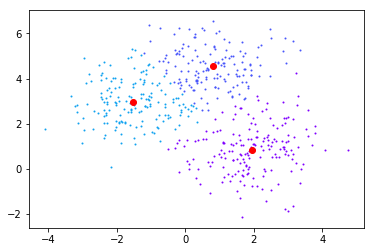

In [18]:
n_clusters = 3
X, y = datasets.make_blobs(n_samples=500, n_features=2, centers=n_clusters, random_state=0)
gm = GMeans_01().fit(X)
print "Ground truth = {}, G-means find k = {}, silhouette_score = {}".format(n_clusters, len(gm.centroids), silhouette_score(X, gm.labels, metric='euclidean'))
Tools.draw(X, gm.labels, gm.centroids, title="g-means") 
plt.show()

Ground truth = 10, G-means find k = 12, silhouette_score = 0.494800455862
use g-means, k = 12


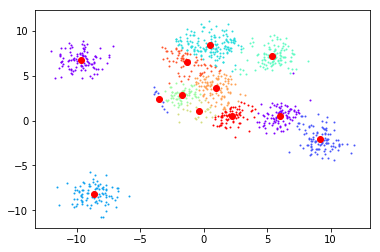

In [19]:
n_clusters = 10
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=n_clusters, random_state=0)
gm = GMeans_01().fit(X)
print "Ground truth = {}, G-means find k = {}, silhouette_score = {}".format(n_clusters, len(gm.centroids), silhouette_score(X, gm.labels, metric='euclidean'))
Tools.draw(X, gm.labels, gm.centroids, title="g-means") 
plt.show()

Ground truth = 10, G-means find k = 9, silhouette_score = 0.559750953971
use g-means, k = 9


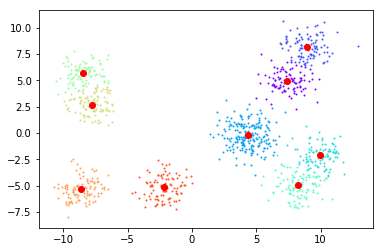

In [20]:
n_clusters = 10
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=n_clusters, random_state=150)
gm = GMeans_01().fit(X)
print "Ground truth = {}, G-means find k = {}, silhouette_score = {}".format(n_clusters, len(gm.centroids), silhouette_score(X, gm.labels, metric='euclidean'))
Tools.draw(X, gm.labels, gm.centroids, title="g-means") 
plt.show()

Event the k = 9 is not the same as ground truth 10. Silhouette_score becomes higher when the data sets seem more separate from each other

Ground truth = 10, G-means find k = 10, silhouette_score = 0.439171221494
use g-means, k = 10


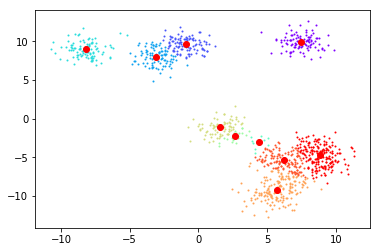

In [21]:
n_clusters = 10
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=n_clusters, random_state=200)
gm = GMeans_01().fit(X)
print "Ground truth = {}, G-means find k = {}, silhouette_score = {}".format(n_clusters, len(gm.centroids), silhouette_score(X, gm.labels, metric='euclidean'))
Tools.draw(X, gm.labels, gm.centroids, title="g-means") 
plt.show()

### Part two, after we found the G-means seems not stable, we do more test to see if it is stable

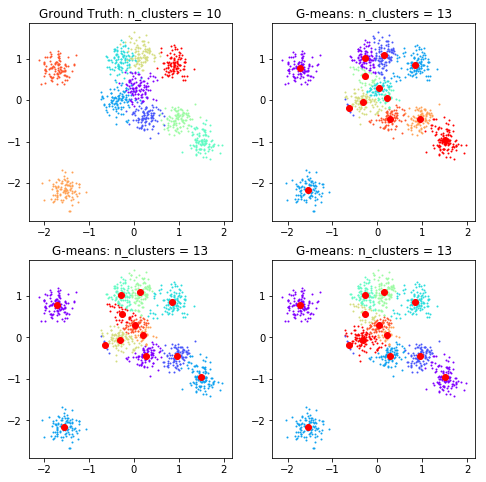

In [28]:
comparison_gm(n_clusters=10, n_samples=1000, n_features=2, random_state=0)

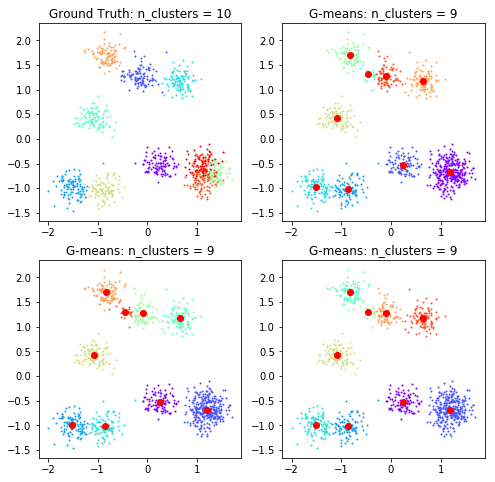

In [29]:
comparison_gm(n_clusters=10, n_samples=1000, n_features=2, random_state=100)

Still, we found that when the clusters are separated well. The G-means can perforace very well
#### From part one and two, we can see G-means can perform well when the data cluster separate well by themselves.  But when different clusters get crowed together, G-means seems to do over clustering. 

### Part Three: what about their comparision with X-means. In paper, G-means is described as can performe better than X-means

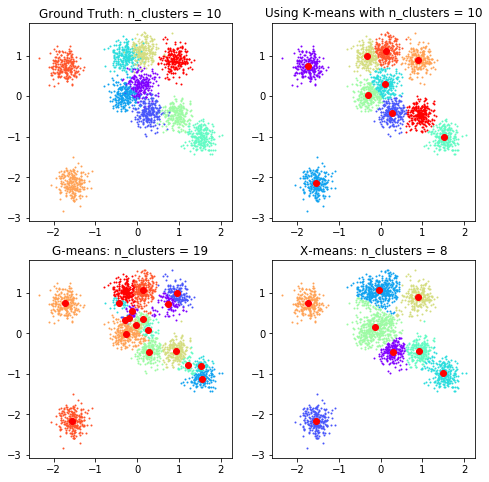

In [31]:
comparison_between_k_x_and_g(n_clusters=10, n_samples=2300, n_features=2, random_state=0)

G-means tend to over cluster the data when the data is not separated from each other. 
When some clusters get crowd together, they do not form a spherical shape. 
In G-means paper, the auther has mentioned that the data need to be spherical.

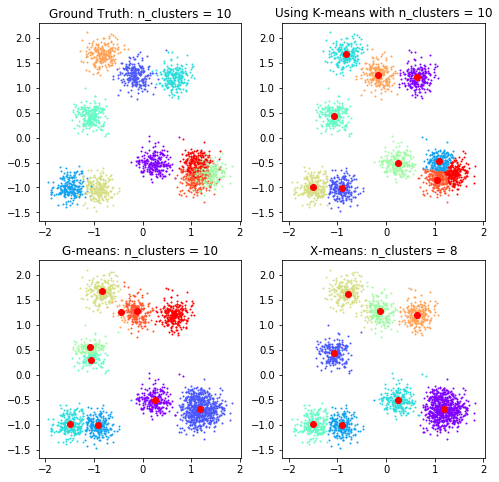

In [32]:
# change random_state=100 to make the cluster seperate from each other
comparison_between_k_x_and_g(n_clusters=10, n_samples=2300, n_features=2, random_state=100) 


Again, it has proved that: if G-means performs well, each data clusters need to be spherical.
#### The X-means seems performs stable and better than G-means.

### Part Four: for curiosity, we compare the G-means and X-means useing different setting for different round, and collect their performance 

n_samples = 1000, n_features = 2, n_cluster = 3, gm_01_score = 0.365994895959, gm_02_score = 0.320427421056, xm_score = 0.473683061999
n_samples = 1000, n_features = 2, n_cluster = 4, gm_01_score = 0.333600416981, gm_02_score = 0.38483772085, xm_score = 0.419323298002
n_samples = 1000, n_features = 2, n_cluster = 5, gm_01_score = 0.394550380913, gm_02_score = 0.321111775156, xm_score = 0.650940922032
n_samples = 1000, n_features = 2, n_cluster = 6, gm_01_score = 0.318849705343, gm_02_score = 0.295270730797, xm_score = 0.417386475896
n_samples = 1000, n_features = 2, n_cluster = 7, gm_01_score = 0.347871997226, gm_02_score = 0.3472189176, xm_score = 0.455537953277
n_samples = 1000, n_features = 2, n_cluster = 8, gm_01_score = 0.462381814266, gm_02_score = 0.480651900047, xm_score = 0.500860982055
n_samples = 1000, n_features = 2, n_cluster = 9, gm_01_score = 0.508419919184, gm_02_score = 0.472254569117, xm_score = 0.564363667828
n_samples = 1000, n_features = 2, n_cluster = 10, gm_01_sc

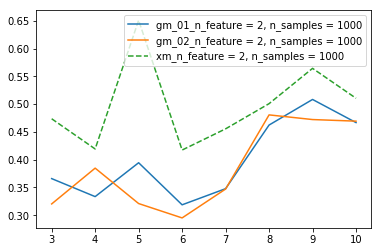

In [36]:
min_n_cluster = 3
max_n_cluster = 10
n_loops = 10
indexes = []
for index in np.linspace(min_n_cluster, max_n_cluster, max_n_cluster - min_n_cluster + 1):
    indexes.append(index)


# sampling
n_features = 2
n_samples = 1000
random_state = 0
gm_01, gm_02, xm = summary(n_samples, min_n_cluster, max_n_cluster, n_features=n_features, random_state=random_state,
                     n_loops=n_loops)

fig = plt.gcf()
fig.canvas.set_window_title(
    "n_samples = {}, n_features = {}, random_state = {}".format(n_samples, n_features, random_state))

plt.plot(indexes, gm_01, label="gm_01_n_feature = {}, n_samples = {}".format(n_features, n_samples))
plt.plot(indexes, gm_02, label="gm_02_n_feature = {}, n_samples = {}".format(n_features, n_samples))
plt.plot(indexes, xm, '--', label="xm_n_feature = {}, n_samples = {}".format(n_features, n_samples))


plt.legend()
plt.show()

gm_01 is the implementation using init=k-means++
gm_02 is the implementation using specified centroids generated from formula in the paper

Ihe result is consistent with our previous result. The X-Means performs better than G-means when feature = 2.
What about in high dimension?

n_samples = 1000, n_features = 20, n_cluster = 3, gm_01_score = 0.647659073071, gm_02_score = 0.647659073071, xm_score = 0.647659073071
n_samples = 1000, n_features = 20, n_cluster = 4, gm_01_score = 0.750423054731, gm_02_score = 0.750423054731, xm_score = 0.750423054731
n_samples = 1000, n_features = 20, n_cluster = 5, gm_01_score = 0.78890355561, gm_02_score = 0.78890355561, xm_score = 0.78890355561
n_samples = 1000, n_features = 20, n_cluster = 6, gm_01_score = 0.782315086816, gm_02_score = 0.782315086816, xm_score = 0.782315086816
n_samples = 1000, n_features = 20, n_cluster = 7, gm_01_score = 0.773990963568, gm_02_score = 0.773990963568, xm_score = 0.773990963568
n_samples = 1000, n_features = 20, n_cluster = 8, gm_01_score = 0.774914378221, gm_02_score = 0.774914378221, xm_score = 0.605219562241
n_samples = 1000, n_features = 20, n_cluster = 9, gm_01_score = 0.767586206923, gm_02_score = 0.767586206923, xm_score = 0.581517682204
n_samples = 1000, n_features = 20, n_cluster = 10, 

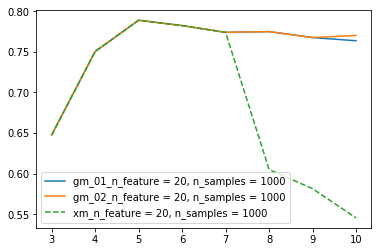

In [37]:
min_n_cluster = 3
max_n_cluster = 10
n_loops = 10
indexes = []
for index in np.linspace(min_n_cluster, max_n_cluster, max_n_cluster - min_n_cluster + 1):
    indexes.append(index)


# sampling
n_features = 20
n_samples = 1000
random_state = 0
gm_01, gm_02, xm = summary(n_samples, min_n_cluster, max_n_cluster, n_features=n_features, random_state=random_state,
                     n_loops=n_loops)

fig = plt.gcf()
fig.canvas.set_window_title(
    "n_samples = {}, n_features = {}, random_state = {}".format(n_samples, n_features, random_state))

plt.plot(indexes, gm_01, label="gm_01_n_feature = {}, n_samples = {}".format(n_features, n_samples))
plt.plot(indexes, gm_02, label="gm_02_n_feature = {}, n_samples = {}".format(n_features, n_samples))
plt.plot(indexes, xm, '--', label="xm_n_feature = {}, n_samples = {}".format(n_features, n_samples))


plt.legend()
plt.show()

When dimention is hight, the gm seems performs better than X-mean. The reason we think is that, we dimension is high, each cluster is much separable than in low dimension. Then when data is relatively easy to separate. G-means can performs very well.

#### What about the case the data is stretch to be long shape?

### Part Five: test data when the data is stretched to some shape, to test if X-means is tend to overfit as the paper claimed.

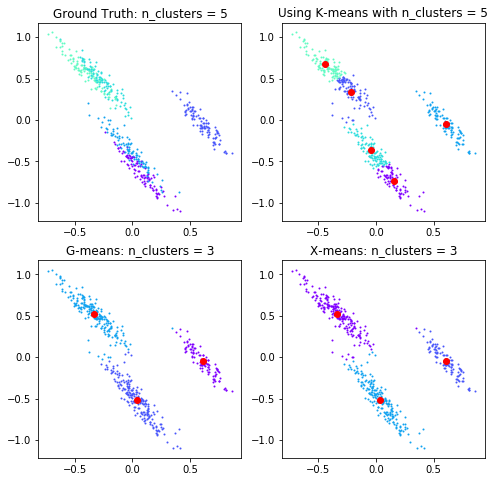

In [45]:
comparison_between_k_x_and_g_with_shaped_data(n_samples=500, n_clusters=5, random_state=90)

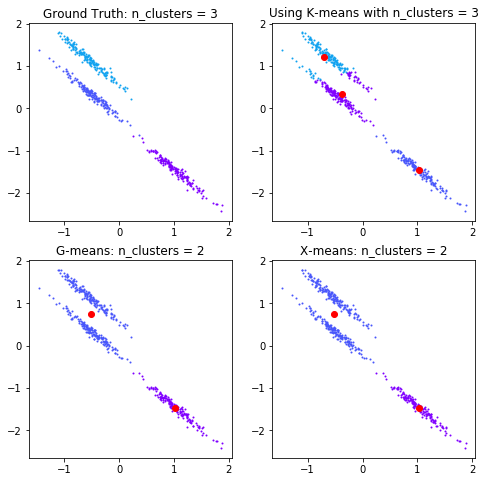

In [47]:
comparison_between_k_x_and_g_with_shaped_data(n_samples=500, n_clusters=3, random_state=50)

#### It seems the X-means did not tend to overfit.

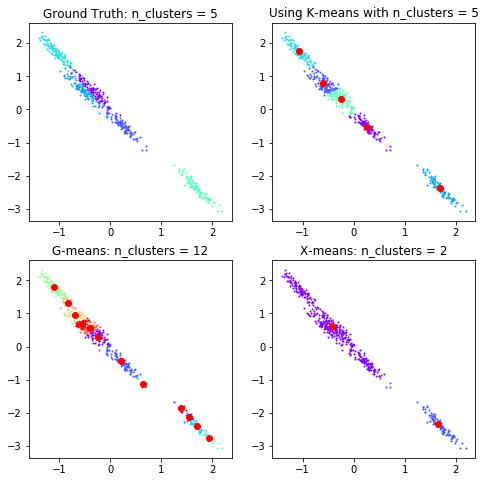

In [48]:
comparison_between_k_x_and_g_with_shaped_data(n_samples=500, n_clusters=5, random_state=0)

#### Again, it seems the G-mean tend to overfit when the clusters are crowed together
### Summary
1. G-means can automatically make a good k when the data is sperately well from each other
2. Otherwise, when data clusters is crowed together, they don't do it well
3. The reason is it must assume the data cluster to separate must be sperical.